In [1]:
import os
from sm_data import generate_prediction_data, generate_NPI_prediction_data
from covid.patients import get_delay_distribution, get_delays_from_patient_data, download_patient_data
from sm_utils import *
from sm_utils import _get_convolution_ready_gt
from sm_model import SemiMechanisticModels

In [2]:
data_path = os.path.join('../covid19-modelling-sg/data/statistics', 'epidemic_curve.csv')
NPI_PATH1 = 'data/NPIS_LC_processed_V7.csv'
NPI_PATH2 = 'data/lockdown_index.csv'

In [3]:
community_input, dorm_input, imported_input, total_input, len_obs = generate_prediction_data(data_path, start_id=50,
                             end_date=495, prediction_t=7, imported_case_extra='last',
                             separate_dorms=True)

Length Community training cases:  495
Length Dorm training cases:  495
Length into model:  502   502   502


In [4]:
NPIS_array, date_ver = generate_NPI_prediction_data(NPI_PATH1, start_id=50, end_date=495, prediction_t=7)
print("NPIS Shape: ", NPIS_array.shape)

NPIS Shape:  (502, 10)


# Model running 

In [5]:
sm_forecast = SemiMechanisticModels()
# Instantiate model based on data
sm_forecast.build_model(local_cases=community_input,
                          dorm_cases=dorm_input,
                          imported_cases=imported_input,
                          NPIS_array=NPIS_array,
                          len_observed=len_obs,
                          total_cases=None,
                          separate_dorms=True,
                          likelihood_fun='PO')

hi


/home/wliangch/miniconda3/envs/pymc3_env_mlflow/lib/python3.9/site-packages/pymc3/model.py:1754: ImputationWarning: Data in Obs_local contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/wliangch/miniconda3/envs/pymc3_env_mlflow/lib/python3.9/site-packages/pymc3/model.py:1754: ImputationWarning: Data in Obs_dorm contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [ ]:
sm_forecast.sample(init_choice='adapt_diag')
#sm_forecast.sample(chains=2, tune=1500, draws=3000)

/home/wliangch/miniconda3/envs/pymc3_env_mlflow/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [Seed_local, Seed_dorm, eps_t, log_eps_t, b_9, b_8, b_7, b_6, b_5, b_4, b_3, b_2, b_1, b_0, log_r_t_local, log_r_t_foreign]
>CompoundStep
>>Metropolis: [Obs_dorm_missing]
>>Metropolis: [Obs_local_missing]


In [11]:
sm_forecast._trace.varnames

['log_r_t_foreign',
 'log_r_t_local',
 'b_0',
 'b_1',
 'b_2',
 'b_3',
 'b_4',
 'b_5',
 'b_6',
 'b_7',
 'b_8',
 'b_9',
 'log_eps_t',
 'eps_t_logodds__',
 'Seed_dorm_log__',
 'Seed_local_log__',
 'Obs_local_missing',
 'Obs_dorm_missing',
 'r_t_foreign',
 'r_t_local',
 'eps_t',
 'Seed_dorm',
 'infections_dorm',
 'Seed_local',
 'infections_local',
 'test adjusted positive local',
 'test_adjusted_positive_jit_local',
 'test adjusted positive dorm',
 'test_adjusted_positive_jit_dorm']

/home/wliangch/miniconda3/envs/pymc3_env_mlflow/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'b_0'}>,
        <AxesSubplot:title={'center':'b_0'}>],
       [<AxesSubplot:title={'center':'b_1'}>,
        <AxesSubplot:title={'center':'b_1'}>],
       [<AxesSubplot:title={'center':'b_2'}>,
        <AxesSubplot:title={'center':'b_2'}>],
       [<AxesSubplot:title={'center':'b_3'}>,
        <AxesSubplot:title={'center':'b_3'}>],
       [<AxesSubplot:title={'center':'b_4'}>,
        <AxesSubplot:title={'center':'b_4'}>],
       [<AxesSubplot:title={'center':'b_5'}>,
        <AxesSubplot:title={'center':'b_5'}>],
       [<AxesSubplot:title={'center':'b_6'}>,
        <AxesSubplot:title={'center':'b_6'}>],
       [<AxesSubplot:title={'center':'b_7'}>,
        <AxesSubplot:title={'center':'b_7'}>],
       [<AxesSubplot:title={'center':'b_8'}>,
        <AxesSubplot:title={'center':'b_8'}>],
       [<AxesSubplot:title={'center':'b_9'}>,
        <AxesSubplot:title={'center':'b_9'}>]], dtype=object)

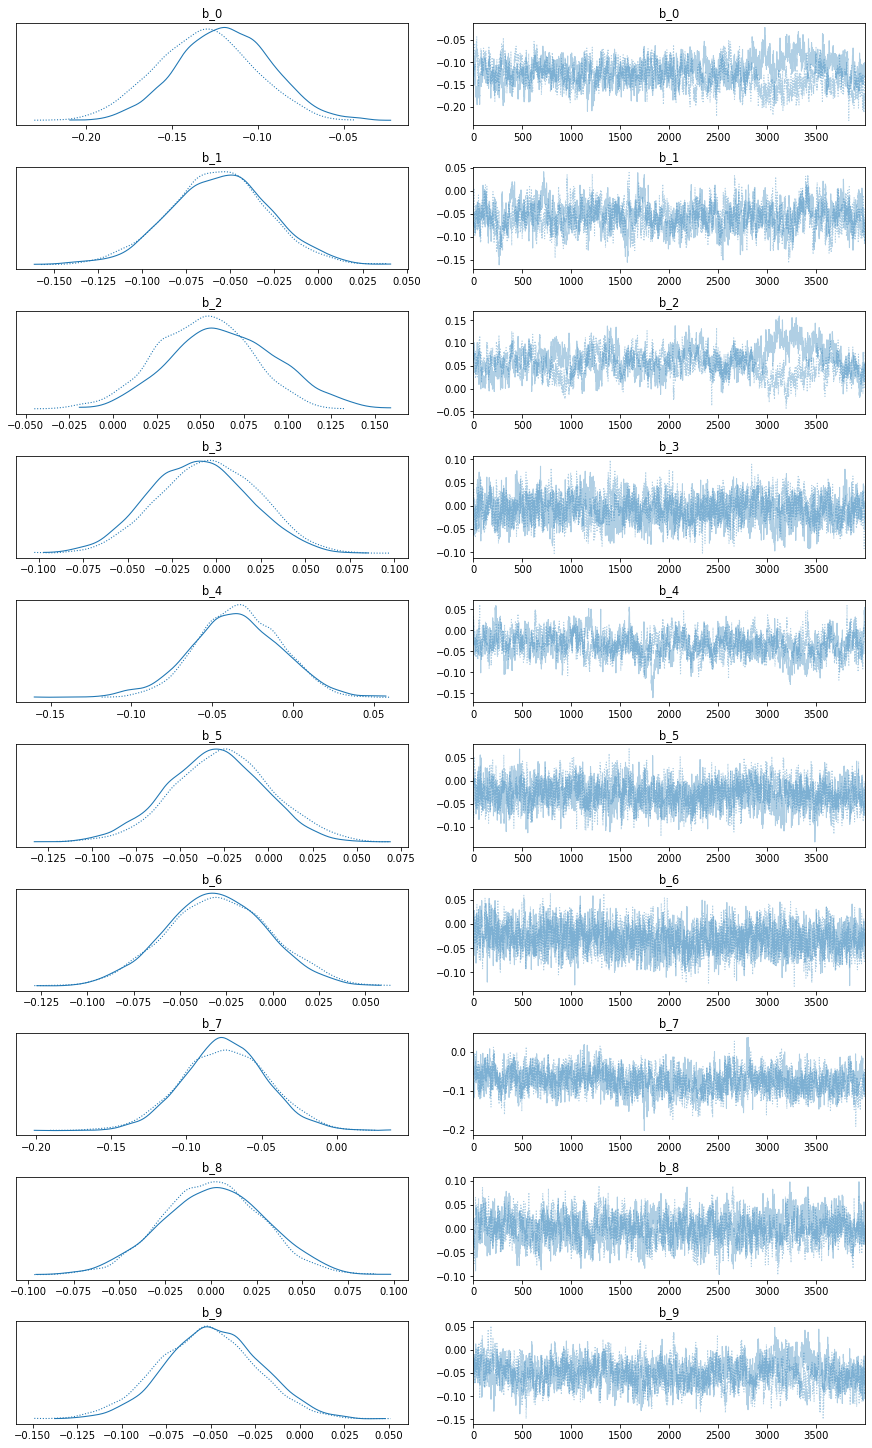

In [12]:
import arviz as az
az.plot_trace(sm_forecast._trace,var_names=['b_'+str(x) for x in range(10)])

In [13]:
start_id = 66
NPIS_proc = pd.read_csv('data/NPIS_LC_processed.csv')
NPIS_wanted = NPIS_proc.iloc[start_id:, 1::]
dict(zip(list(NPIS_wanted.columns[1:]),['b_'+str(x) for x in range(10)]))

{'Compulsory_Mask': 'b_0',
 'Eat_In_Ban': 'b_1',
 'Entry_Recording': 'b_2',
 'Lockdown': 'b_3',
 'Sch_Closure': 'b_4',
 'Gathering_Max': 'b_5',
 'Mall_Distancing': 'b_6',
 'Recreation': 'b_7',
 'Workplace_Closure': 'b_8',
 'Worship': 'b_9'}

# Covariates


Restrictions

0. Compulsory Mask (**Negative**) ----> Binary variable, 0 means no intervention, 1 means intervention is in effect
1. Eat in Ban  (**Negative**) --------> Binary variable, 0 means no intervention, 1 means intervention is in effect
2. Entry Recording (**Negative**) ----> Binary variable, 0 means no intervention, 1 means intervention is in effect
3. Lockdown (**Negative**) -----------> Binary variable, 0 means no intervention, 1 means intervention is in effect
4. School Closure (**Negative**) -----> Binary variable, 0 means no intervention, 1 means intervention is in effect
5. Max Gathering Size (**Negative**) -> Transformed with 1/2^(X). Fairly small value when gathering size is large
6. Mall Distancing (**Negative**) ----> Rescaled to 0-1 from 0-32
7. Recreation (**Negative**) ---------> 1 - X
8. Workplace Closure (**Negative**) --> 1 - X
9. Worship (**Negative**) ------------> 1 - X



In [14]:
az.summary(sm_forecast._trace,var_names=['b_'+str(x) for x in range(10)])

/home/wliangch/miniconda3/envs/pymc3_env_mlflow/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_0,-0.125,0.028,-0.179,-0.074,0.009,0.007,10.0,59.0,1.16
b_1,-0.057,0.028,-0.111,-0.003,0.002,0.001,294.0,836.0,1.00
b_2,0.058,0.029,0.003,0.112,0.007,0.005,20.0,64.0,1.10
b_3,-0.007,0.028,-0.059,0.044,0.002,0.001,262.0,987.0,1.01
b_4,-0.034,0.027,-0.083,0.019,0.002,0.002,173.0,352.0,1.01
b_5,-0.028,0.028,-0.081,0.024,0.002,0.001,300.0,1294.0,1.01
b_6,-0.030,0.028,-0.080,0.024,0.002,0.001,234.0,1931.0,1.02
b_7,-0.075,0.028,-0.124,-0.018,0.002,0.002,128.0,509.0,1.03
b_8,0.001,0.028,-0.050,0.054,0.002,0.001,242.0,1054.0,1.01
b_9,-0.050,0.027,-0.099,0.003,0.002,0.002,132.0,333.0,1.03
